In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
from scipy.optimize import curve_fit

In [3]:
datadir = 'C:/Users/khana/Documents/Masters/Semester 2/Earth and System Modelling/PLASIM/PLASIM Data/'
m100 = xr.open_dataset(datadir + 'm100_monthly.nc')
onepct = xr.open_dataset(datadir + 'onepct_monthly.nc')
double = xr.open_dataset(datadir + 'doubleCO2_monthly.nc')
preind = xr.open_dataset(datadir + 'preind_atm_monthly.nc')

In [4]:
#taking mean over latitude and longitude so we can plot time
GMST_m100 = m100.ts.mean('lat').mean('lon')
GMST_onepct = onepct.ts.mean('lat').mean('lon')
GMST_double = double.ts.mean('lat').mean('lon')
GMST_preind = preind.ts.mean('lat').mean('lon')

In [5]:
pre_ind = np.sum(GMST_preind)/360
pre_ind

<xarray.DataArray 'ts' ()>
array(274.44253472)

In [6]:
#creating a time array to help with plotting
time_m100 = np.arange(0,30,1)
time_onepct = np.arange(0,125,1)
time_double = np.arange(0,110,1)

In [7]:
#to store the new yearly mean surface temperature
GMST_m100_mm = np.zeros(len(time_m100))
GMST_onepct_mm = np.zeros(len(time_onepct))
GMST_double_mm = np.zeros(len(time_double))
#GMST_preind_mm = np.zeros(len(time_m100))

#loop that calculates the yearly mean temp for each year in the given dataset
for i in range(len(time_m100)):
    GMST_m100_mm[i] = np.sum(GMST_m100[12*i:12*(i+1)])/12

for i in range(len(time_onepct)):
    GMST_onepct_mm[i] = np.sum(GMST_onepct[12*i:12*(i+1)])/12

for i in range(len(time_double)):
    GMST_double_mm[i] = np.sum(GMST_double[12*i:12*(i+1)])/12
    
# for i in range(len(time_m100)):
#     GMST_preind_mm[i] = np.sum(GMST_preind[12*i:12*(i+1)])/12

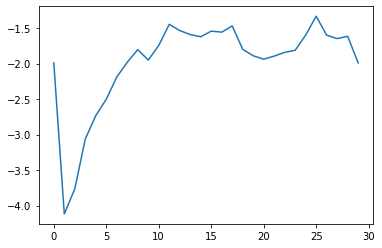

In [8]:
plt.plot(time_m100,GMST_m100_mm - 276.75772222)

In [9]:
# #plotting the yearly mean over time
# fig = plt.figure(figsize = (18,6))
# ax1,ax2,ax3 = fig.subplots(1,3)

# ax1.plot(time_onepct,GMST_onepct_mm, label='Yearly average GMST (1pct)')
# ax1.set_xlabel('time [in yrs]')
# ax1.set_ylabel('Temp [in K]')
# ax1.legend()
# ax1.grid()

# ax2.plot(time_double,GMST_double_mm, label='Yearly average GMST (double)')
# ax2.set_xlabel('time [in yrs]')
# ax2.set_ylabel('Temp [in K]')
# ax2.legend()
# ax2.grid()

# ax3.plot(time_m100,GMST_m100_mm, label='Yearly average GMST (m100)')
# ax3.set_xlabel('time [in yrs]')
# ax3.set_ylabel('Temp [in K]')
# ax3.legend()
# ax3.grid()

# plt.tight_layout()

In [10]:
# #all the plots together
# plt.figure(figsize=(12,6))
# plt.plot(time_onepct,GMST_onepct_mm, label='Yearly average GMST (1pct)')
# plt.plot(time_double,GMST_double_mm, label='Yearly average GMST (double)')
# plt.plot(time_m100,GMST_m100_mm, label='Yearly average GMST (m100)')
# plt.legend()
# plt.grid()
# plt.show()

In [11]:
#define the carbon concentration (C(tau)) and their forcing F(tau)
def m100_carbon(tau):
    CO2 = [285 for i in range(len(time_m100))]
    CO2[1] = CO2[0] - 100
    return CO2[tau]

def m100_F(tau):
    return (3.74/np.log(2))*np.log(m100_carbon(tau)/m100_carbon(0))

In [12]:
#function that calculates the sum using the formula above
def m100_temp(t,q1,q2,d1,d2):
    
    temp = []
    T = []
    dx = np.zeros(shape=(len(t), len(t)))
    R = np.zeros(shape=(len(t), len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            if i >= j:
                dx[i][j] = i - j
                R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)
            temp.append(R[i][j]*m100_F(j))
        T.append(np.sum(temp[len(t)*i:len(t)*(i+1)]))    
    
    return T

In [14]:
#curve fit
m100_fit, _ = curve_fit(m100_temp, time_m100, GMST_m100_mm - 276.75772222)
print('fit values for m100:',m100_fit)

<ipython-input-12-c1a707f517fc>:13: RuntimeWarning: overflow encountered in exp
  R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)
<ipython-input-12-c1a707f517fc>:14: RuntimeWarning: invalid value encountered in double_scalars
  temp.append(R[i][j]*m100_F(j))


fit values for m100: [1.13045185e+00 7.08647190e-01 3.13404200e+00 2.07006151e+08]


In [15]:
#the ECS seems to be close to what we want

m100_ECS = 3.74 * (m100_fit[0] + m100_fit[1])
m100_ECS

6.878230412167432

In [16]:
#TCR is no-where near what we want, because the d1,d2 values are wrong

m100_TCR = 3.74 * (m100_fit[0]*(1-m100_fit[2]/70*(1-np.exp(-70/m100_fit[2]))) 
                   + m100_fit[1]* (1-m100_fit[3]/70*(1-np.exp(-70/m100_fit[3]))))
m100_TCR

4.038599160421461

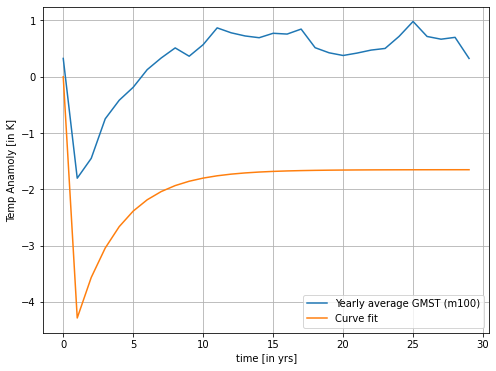

In [17]:
fig = plt.figure(figsize = (8,6))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(time_m100, GMST_m100_mm - 274.44253472, label='Yearly average GMST (m100)')
ax1.plot(time_m100, m100_temp(time_m100, *m100_fit), label='Curve fit')
ax1.set_xlabel('time [in yrs]')
ax1.set_ylabel('Temp Anamoly [in K]')
ax1.legend()
ax1.grid()

In [ ]:
# define results as easy to use emulator
def emulator_pulse(t):
    return m100_temp(t,m100_fit[0],m100_fit[1],m100_fit[2],m100_fit[3])

In [ ]:
def onepct_carbon(tau):
    CO2 = [285 for i in range(len(time_onepct))]
    for i in range(len(time_onepct)-1):
        if (21<=i<=90):
            CO2[i + 1] = CO2[i] + 0.01 * CO2[i]
        if (91<=i):
            CO2[i] = 571.9
    return CO2[tau]

def onepct_F(tau):
    return (3.74/np.log(2))*np.log(onepct_carbon(tau)/onepct_carbon(0))

In [ ]:
def onepct_temp(t,q1,d1,q2,d2):
    
    temp = []
    T = []
    dx = np.zeros(shape=(len(t), len(t)))
    R = np.zeros(shape=(len(t), len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            if i >= j:
                dx[i][j] = i - j
                R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)
            temp.append(R[i][j]*onepct_F(j))
        T.append(np.sum(temp[len(t)*i:len(t)*(i+1)]))    
    
    return T

In [ ]:
#this is not working! but I think my definition of 1pct is wrong maybe?

onepct_fit, _ = curve_fit(onepct_temp, time_onepct, GMST_onepct_mm - GMST_onepct_mm[0])
print('fit values for onepct:',onepct_fit)

In [ ]:
onepct_ECS = 3.74 * (onepct_fit[0] + onepct_fit[1])
onepct_ECS

In [ ]:
onepct_TCR = 3.74 * (onepct_fit[0]*(1-onepct_fit[2]/70*(1-np.exp(-70/onepct_fit[2]))) 
                   + onepct_fit[1]* (1-onepct_fit[3]/70*(1-np.exp(-70/onepct_fit[3]))))
onepct_TCR

In [ ]:
fig = plt.figure(figsize = (8,6))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(time_onepct, GMST_onepct_mm - GMST_onepct_mm[0], label='Yearly average GMST (1pct)')
ax1.plot(time_onepct, onepct_temp(time_onepct, *onepct_fit))
ax1.plot(time_onepct, emulator)
ax1.set_xlabel('time [in yrs]')
ax1.set_ylabel('Temp Anamoly [in K]')
ax1.legend()
ax1.grid()


In [ ]:
def double_carbon(tau):
    CO2 = [285 for i in range(len(time_double))]
    CO2[1] = CO2[0] * 2
    return CO2[tau]

def double_F(tau):
    return (3.74/np.log(2))*np.log(double_carbon(tau)/double_carbon(0))

In [ ]:
def double_temp(t,q1,q2,d1,d2):
    
    temp = []
    T = []
    dx = np.zeros(shape=(len(t), len(t)))
    R = np.zeros(shape=(len(t), len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            if i >= j:
                dx[i][j] = i - j
                R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)
            temp.append(R[i][j]*double_F(j))
        T.append(np.sum(temp[len(t)*i:len(t)*(i+1)]))    
    
    return T

In [ ]:
#curve fit for the double forcing
double_fit, _ = curve_fit(double_temp, time_double, GMST_double_mm - GMST_double_mm[0])
print('fit values for double:',double_fit)

In [ ]:
#its all over the place!

double_ECS = 3.74 * (double_fit[0]+double_fit[1])
double_ECS

In [ ]:
#doesn't look nice

double_TCR = 3.74 * (double_fit[0]*(1-double_fit[2]/70*(1-np.exp(-70/double_fit[2]))) 
                   + double_fit[1]* (1-double_fit[3]/70*(1-np.exp(-70/double_fit[3]))))
double_TCR

In [ ]:
fig = plt.figure(figsize = (8,6))
ax2 = fig.add_subplot(1,1,1)

ax2.plot(time_double, GMST_double_mm - GMST_double_mm[0], label='Yearly average GMST (double)')
ax2.plot(time_double, double_temp(time_double, *double_fit), label='Curve fit')
ax2.set_xlabel('time [in yrs]')
ax2.set_ylabel('Temp Anamoly [in K]')
ax2.legend()
ax2.grid()

In [ ]:
#everything together


fig = plt.figure(figsize = (18,6))
ax1,ax2,ax3 = fig.subplots(1,3)

ax1.plot(time_onepct, GMST_onepct_mm - GMST_onepct_mm[0], label='Yearly average GMST (1pct)')
ax1.plot(time_onepct, onepct_temp(time_onepct, *onepct_fit))
ax1.set_xlabel('time [in yrs]')
ax1.set_ylabel('Temp Anamoly [in K]')
ax1.legend()
ax1.grid()

ax2.plot(time_double, GMST_double_mm - GMST_double_mm[0], label='Yearly average GMST (double)')
ax2.plot(time_double, double_temp(time_double, *double_fit), label='Curve fit')
ax2.set_xlabel('time [in yrs]')
ax2.set_ylabel('Temp Anamoly [in K]')
ax2.legend()
ax2.grid()

ax3.plot(time_m100, GMST_m100_mm - GMST_m100_mm[0], label='Yearly average GMST (m100)')
ax3.plot(time_m100, m100_temp(time_m100, *m100_fit), label='Curve fit')
ax3.set_xlabel('time [in yrs]')
ax3.set_ylabel('Temp Anamoly [in K]')
ax3.legend()
ax3.grid()

plt.tight_layout()